In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

from sklearn.preprocessing import PolynomialFeatures

sys.path.insert(1, "../src")
from Loess import *

In [2]:
df = pd.read_csv("datasets/dataset.csv")

# Data
X = df[["radiation", "temperature", "wind"]].to_numpy()
# Target variable
y = df["ozone"].to_numpy()

# Experiments (section 5 paper)

---
## Normal probability plot

In [3]:
loess = Loess(X, y)

f = 0.4

y_hat = np.array([loess.estimate(x, kernel="tricubic", window=int(len(X)*f), degree=1) for x in X])

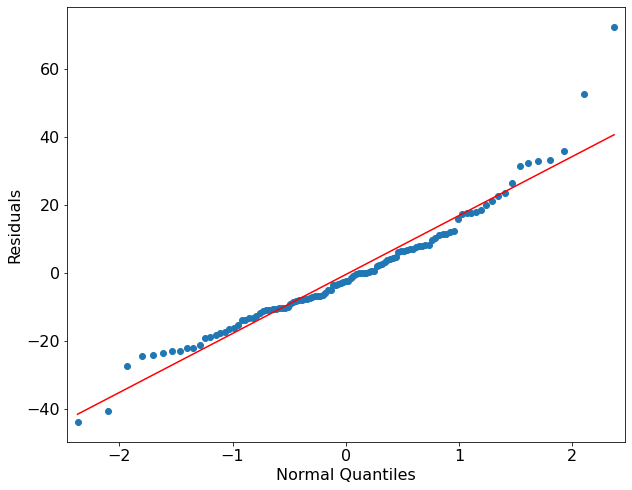

In [4]:
import seaborn as sns
import statsmodels.graphics.gofplots as sm

residuals = y - y_hat

import matplotlib as mpl

with mpl.rc_context():
    mpl.rc("figure", figsize=(10,8))
    
    sm.ProbPlot(residuals).qqplot(line="s", xlabel="Normal Quantiles", ylabel="Residuals")
    plt.savefig("img/qqplot_residuals.png")

In [5]:
f = 2/3

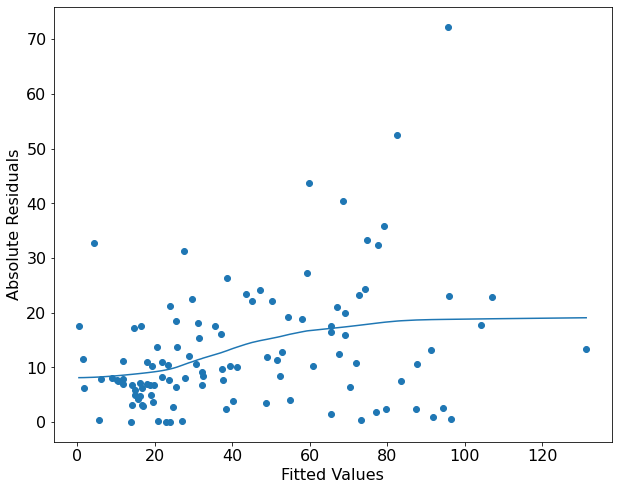

In [6]:
loess = Loess(y_hat, np.abs(residuals))

reg_residuals = np.array([loess.estimate(x, kernel="tricubic", window=int(len(X)*f), degree=1) for x in y_hat.reshape((111,1))])

reg_residuals = reg_residuals[np.argsort(y_hat)]

y_hat_a = np.sort(y_hat)

# residuals = residuals[np.argsort(y_hat)]

fig = plt.figure(figsize=(10,8))
plt.scatter(y_hat, np.abs(residuals))
plt.plot(y_hat_a, reg_residuals)
plt.xlabel("Fitted Values")
plt.ylabel("Absolute Residuals")
plt.savefig("img/fitted_abs_res.png")

In [7]:
def var_vs_residual(variable):
    data = df[variable].to_numpy()

    loess = Loess(data, residuals)

    reg_residuals = np.array([loess.estimate(x, kernel="tricubic", window=int(len(data)*f), degree=1) for x in data.reshape((111,1))])

    reg_residuals = reg_residuals[np.argsort(data)]

    y_hat = np.sort(data)
    
    fig = plt.figure(figsize=(10,8))
    plt.scatter(data, residuals)
    plt.plot(y_hat, reg_residuals)
    plt.xlabel(variable)
    plt.ylabel("Residuals")
    plt.savefig(f"img/{variable}_vs_residual.png")

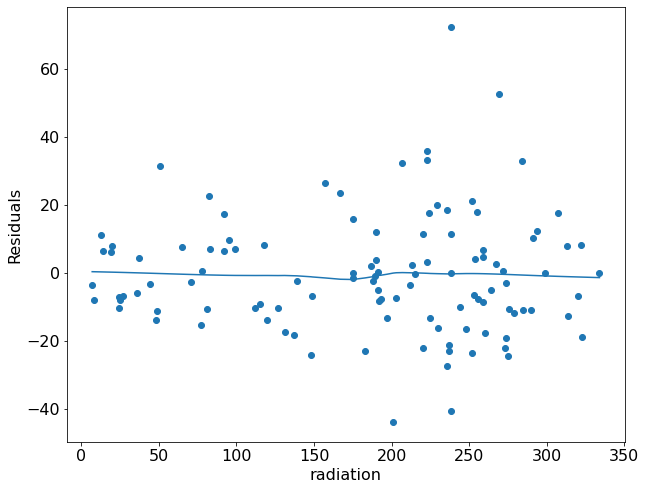

In [8]:
var_vs_residual("radiation")

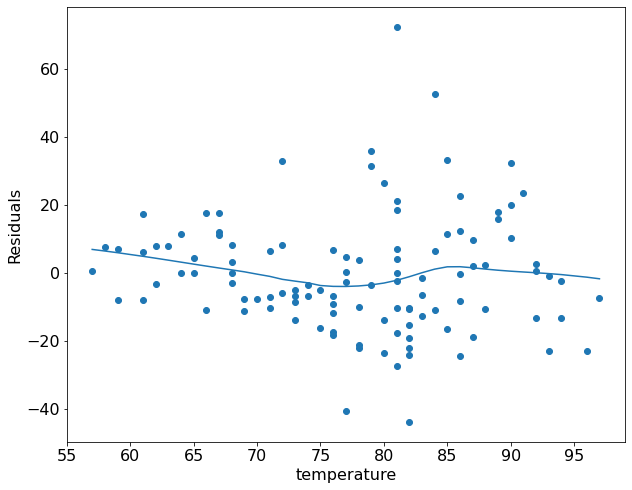

In [9]:
var_vs_residual("temperature")

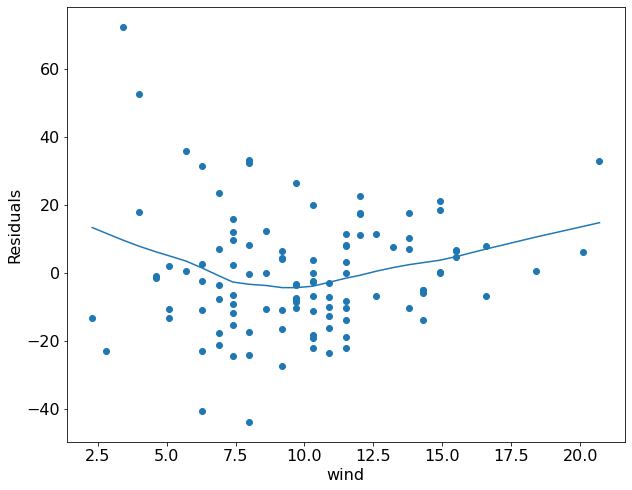

In [10]:
var_vs_residual("wind")
# Este grafico no nos quedo igual que en el paper pero muy parecido. 
# Podemos indicar en el informe que una de las dificultades que tuvimos fue que no pudimos recrear exactamente los graficos del paper
# Ya que los residuales obtenidos son distintos debido a las diferencias en implementacion de Loess

## Figures Page 601

In [11]:
radiations = [50, 170, 290]
winds = [5, 10, 15]
temperatures = [62, 76, 90]

max_vals = X.max(axis=0)
min_vals = X.min(axis=0)

var_radiations = X[:, 0]
# var_temperatures = np.arange(min_vals[1], max_vals[1]) # Restamos 7 ya que la regresion no tomaba suficientes valores y arrojaba valores negativos
var_temperatures = X[:, 1]
var_winds = X[:, 2]

In [12]:
fig_6_data = np.array([[[r, t, w] for t in var_temperatures] for r in radiations for w in winds])

fig_7_data = np.array([[[r, t, w] for r in var_radiations] for t in temperatures for w in winds])

fig_8_data = np.array([[[r, t, w] for w in var_winds] for r in radiations for t in temperatures])

idx_array = [6,7,8,3,4,5,0,1,2]

In [13]:
X = df[["radiation", "temperature", "wind"]].to_numpy()
# Target variable
y = df["ozone"].to_numpy()

loess = Loess(df[["radiation", "temperature", "wind"]].to_numpy(), df["ozone"].to_numpy())

f = 0.8

In [14]:
def plot_fig_6_8(data_list, pos):
    pred = np.array([[loess.estimate(x, "tricubic", window=int(len(data)*f), degree=2) for x in data] for data in data_list])
    
    fig = plt.figure(figsize=(8, 8))
    axes = [plt.subplot2grid((3, 3), (i, j)) for i in range(3) for j in range(3)]
    
    inputX = data_list[0][:, pos]
    
    print(inputX)
    
    for i in range(len(data_list)):
        axes[idx_array[i]].plot(np.sort(inputX), np.cbrt(pred[i][np.argsort(inputX)]))
        axes[idx_array[i]].set_ylim([0, 7])
        if pos == 2:
            axes[idx_array[i]].set_xticks([4, 8, 12, 16],[4, 8, 12, 16])
        if i in [3,4,5,6,7,8]:
            axes[idx_array[i]].set_xticks([],[])
        if i not in [0,3,6]:
            # Solo ponemos los y ticks en los subgraphs de la izquierda
            axes[idx_array[i]].set_yticks([],[])
        else:
            axes[idx_array[i]].set_yticks([1,4,7],[1,4,7])
    
    
    return plt

[67. 72. 74. 62. 65. 59. 61. 69. 66. 68. 58. 64. 66. 57. 68. 62. 59. 73.
 61. 61. 67. 81. 79. 76. 82. 90. 87. 82. 77. 72. 65. 73. 76. 84. 85. 81.
 83. 83. 88. 92. 92. 89. 73. 81. 80. 81. 82. 84. 87. 85. 74. 86. 85. 82.
 86. 88. 86. 83. 81. 81. 81. 82. 89. 90. 90. 86. 82. 80. 77. 79. 76. 78.
 78. 77. 72. 79. 81. 86. 97. 94. 96. 94. 91. 92. 93. 93. 87. 84. 80. 78.
 75. 73. 81. 76. 77. 71. 71. 78. 67. 76. 68. 82. 64. 71. 81. 69. 63. 70.
 75. 76. 68.]


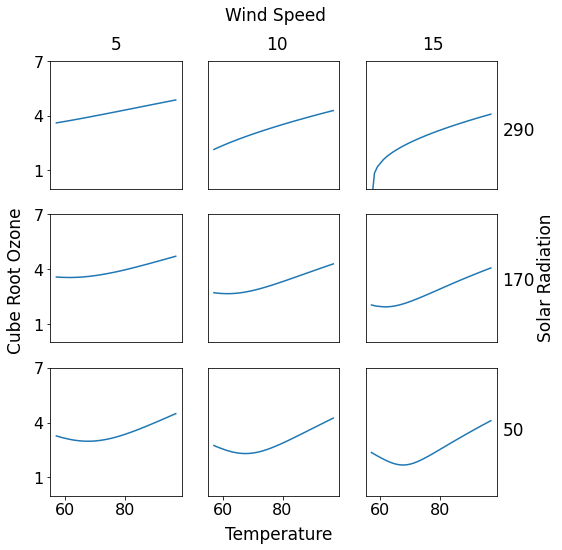

In [15]:
plot = plot_fig_6_8(fig_6_data, 1)

plot.text(0.05, 0.38, "Cube Root Ozone", fontsize=17, rotation=90, transform=plt.gcf().transFigure)
plot.text(0.428, 0.95, "Wind Speed", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.23, 0.9, "5", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.5, 0.9, "10", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.77, 0.9, "15", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.97, 0.40, "Solar Radiation", fontsize=17, rotation=90, transform=plt.gcf().transFigure)
plt.text(0.91, 0.23, "50", fontsize=17, transform=plt.gcf().transFigure)
plt.text(0.91, 0.49, "170", fontsize=17, transform=plt.gcf().transFigure)
plt.text(0.91, 0.75, "290", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.428, 0.05, "Temperature", fontsize=17, transform=plt.gcf().transFigure)
plot.savefig("img/fig_8.png")

[190. 118. 149. 313. 299.  99.  19. 256. 290. 274.  65. 334. 307.  78.
 322.  44.   8. 320.  25.  92.  13. 252. 223. 279. 127. 291. 323. 148.
 191. 284.  37. 120. 137. 269. 248. 236. 175. 314. 276. 267. 272. 175.
 264. 175.  48. 260. 274. 285. 187. 220.   7. 294. 223.  81.  82. 213.
 275. 253. 254.  83.  24.  77. 255. 229. 207. 192. 273. 157.  71.  51.
 115. 244. 190. 259.  36. 212. 238. 215. 203. 225. 237. 188. 167. 197.
 183. 189.  95.  92. 252. 220. 230. 259. 236. 259. 238.  24. 112. 237.
 224.  27. 238. 201. 238.  14. 139.  49.  20. 193. 191. 131. 223.]


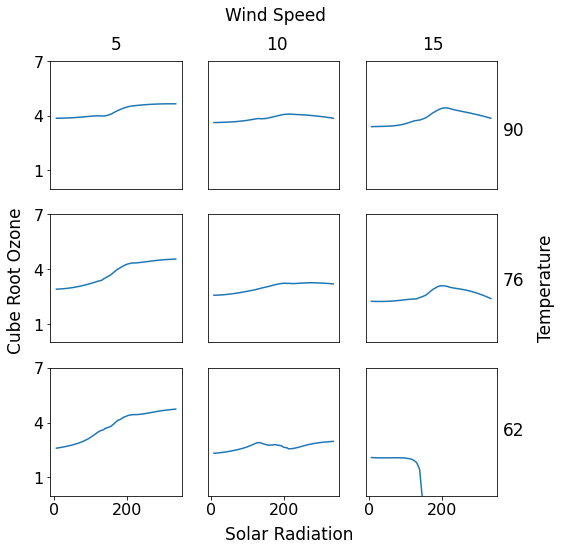

In [154]:
plot = plot_fig_6_8(fig_7_data, 0)

plot.text(0.05, 0.38, "Cube Root Ozone", fontsize=17, rotation=90, transform=plt.gcf().transFigure)
plot.text(0.428, 0.95, "Wind Speed", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.23, 0.9, "5", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.5, 0.9, "10", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.77, 0.9, "15", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.97, 0.40, "Temperature", fontsize=17, rotation=90, transform=plt.gcf().transFigure)
plt.text(0.91, 0.23, "62", fontsize=17, transform=plt.gcf().transFigure)
plt.text(0.91, 0.49, "76", fontsize=17, transform=plt.gcf().transFigure)
plt.text(0.91, 0.75, "90", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.428, 0.05, "Solar Radiation", fontsize=17, transform=plt.gcf().transFigure)
plot.savefig("img/fig_7.png")

[ 7.4  8.  12.6 11.5  8.6 13.8 20.1  9.7  9.2 10.9 13.2 11.5 12.  18.4
 11.5  9.7  9.7 16.6  9.7 12.  12.  14.9  5.7  7.4  9.7 13.8 11.5  8.
 14.9 20.7  9.2 11.5 10.3  4.   9.2  9.2  4.6 10.9  5.1  6.3  5.7  7.4
 14.3 14.9 14.3  6.9 10.3  6.3  5.1 11.5  6.9  8.6  8.   8.6 12.   7.4
  7.4  7.4  9.2  6.9 13.8  7.4  4.  10.3  8.  11.5 11.5  9.7 10.3  6.3
  7.4 10.9 10.3 15.5 14.3  9.7  3.4  8.   9.7  2.3  6.3  6.3  6.9  5.1
  2.8  4.6  7.4 15.5 10.9 10.3 10.9  9.7 14.9 15.5  6.3 10.9 11.5  6.9
 13.8 10.3 10.3  8.  12.6  9.2 10.3 10.3 16.6  6.9 14.3  8.  11.5]


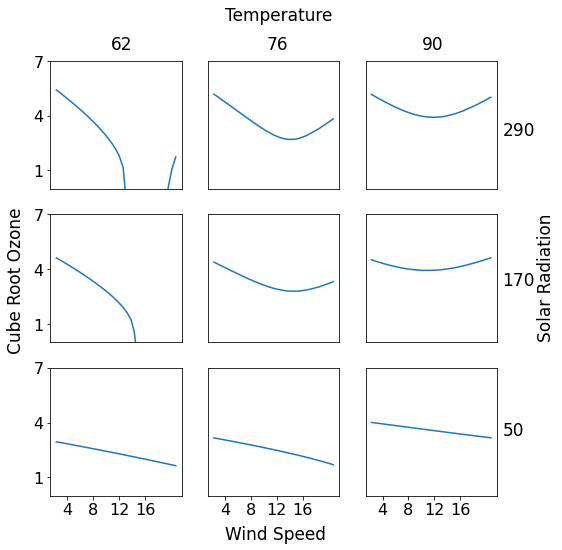

In [151]:
plot = plot_fig_6_8(fig_8_data, 2)

plot.text(0.05, 0.38, "Cube Root Ozone", fontsize=17, rotation=90, transform=plt.gcf().transFigure)
plot.text(0.428, 0.95, "Temperature", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.23, 0.9, "62", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.5, 0.9, "76", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.77, 0.9, "90", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.97, 0.40, "Solar Radiation", fontsize=17, rotation=90, transform=plt.gcf().transFigure)
plt.text(0.91, 0.23, "50", fontsize=17, transform=plt.gcf().transFigure)
plt.text(0.91, 0.49, "170", fontsize=17, transform=plt.gcf().transFigure)
plt.text(0.91, 0.75, "290", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.428, 0.05, "Wind Speed", fontsize=17, transform=plt.gcf().transFigure)
plot.savefig("img/fig_6.png")

---
# Probando con la seno

In [41]:
X = np.linspace(0, 2, num=100)
y_s = np.sin(X * np.pi) + np.cos(X * np.pi) + (np.random.normal(0, 0.15, size=len(X)))

y_o = np.sin(X * np.pi) + np.cos(X * np.pi)

l = Loess(X, y_s)

In [42]:
degrees = [1, 2]
n = X.shape[0]
q = list(range(5, n, 25))
f = [q_i / n for q_i in q]
dist_funcs = ["bisquare", "tricubic"]

f

[0.05, 0.3, 0.55, 0.8]

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

1-bisquare
1-tricubic
2-bisquare
2-tricubic


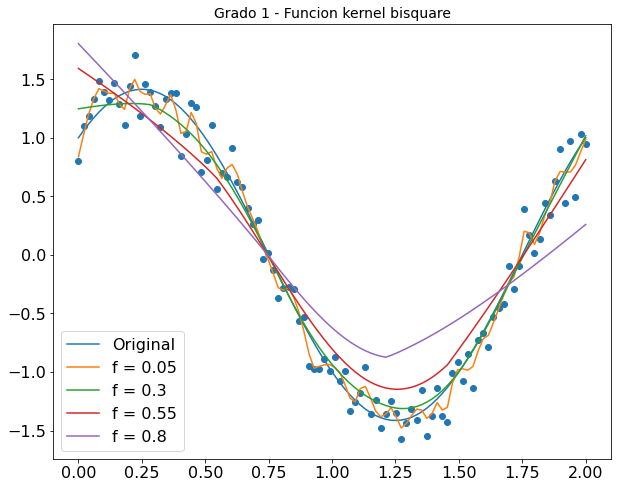

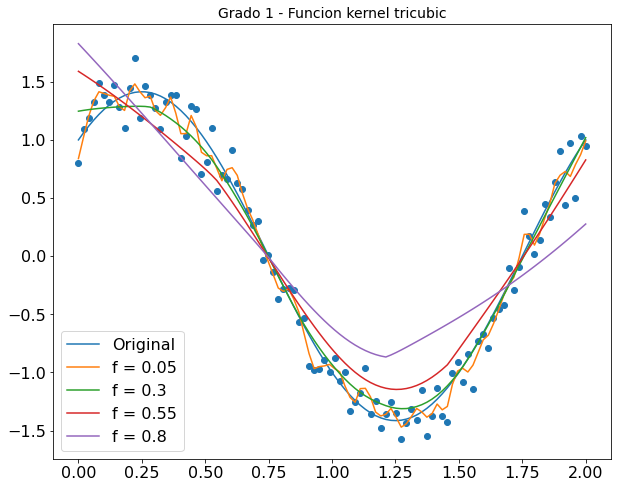

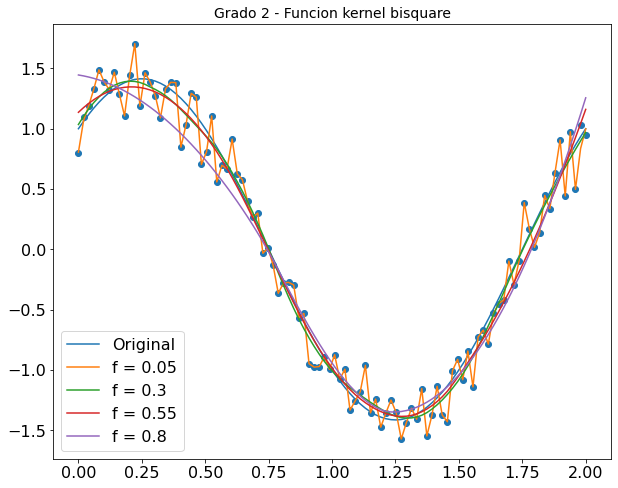

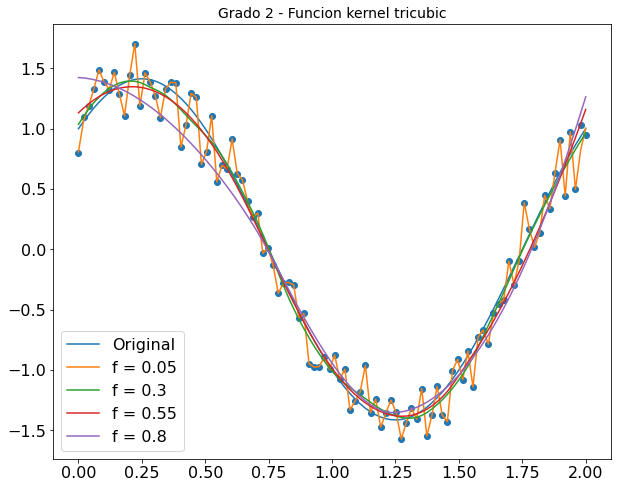

In [44]:
metrics = {}

for d in degrees:
    for func in dist_funcs:
        print(f"{d}-{func}")
        fig = plt.figure(figsize=(10,8))
        plt.scatter(X, y_s)
        plt.plot(X, y_o, label="Original")
        for frac in f:
            y_t = np.array([l.estimate(x, kernel=func, window=int(n*frac), degree=d) for x in X.reshape((100,1))])
            metrics[f"{d}-{func}-{frac}"] = {
                "MAE": mean_absolute_error(y_o, y_t)
            }
            plt.plot(X, y_t, label=f"f = {frac}")
        
        plt.title(f"Grado {d} - Funcion kernel {func}", fontsize=14)
        plt.legend()
        plt.savefig(f"img/exp2_{d}_{func}")

In [45]:
metrics

{'1-bisquare-0.05': {'MAE': 0.07841606625398968},
 '1-bisquare-0.3': {'MAE': 0.062010934037224255},
 '1-bisquare-0.55': {'MAE': 0.1830445460640519},
 '1-bisquare-0.8': {'MAE': 0.3533170956968298},
 '1-tricubic-0.05': {'MAE': 0.07654357754957349},
 '1-tricubic-0.3': {'MAE': 0.06264101652875231},
 '1-tricubic-0.55': {'MAE': 0.1856948275109241},
 '1-tricubic-0.8': {'MAE': 0.3618385235953066},
 '2-bisquare-0.05': {'MAE': 0.1307143856976512},
 '2-bisquare-0.3': {'MAE': 0.04257014236128512},
 '2-bisquare-0.55': {'MAE': 0.05282681805824375},
 '2-bisquare-0.8': {'MAE': 0.12024935902629796},
 '2-tricubic-0.05': {'MAE': 0.1308600092441211},
 '2-tricubic-0.3': {'MAE': 0.04267432521388925},
 '2-tricubic-0.55': {'MAE': 0.05203758073026545},
 '2-tricubic-0.8': {'MAE': 0.11844113627046023}}

In [16]:
0.07841606625398968
0.062010934037224255
0.1830445460640519
0.3533170956968298
0.07654357754957349
0.06264101652875231
0.1856948275109241
0.3618385235953066
0.1307143856976512
0.04257014236128512
0.05282681805824375
0.12024935902629796
0.1308600092441211
0.04267432521388925
0.05203758073026545
0.11844113627046023

0.11844113627046023